<h3>Report</h3>

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import pickle

<h3>Loading Models</h3>

In [3]:
from core.network import *
from core.trainer import *

In [4]:
device = torch.device("cuda:0")
dir_load = '../models/'

In [5]:
net = LSTM(1, 98, 9, num_layers=3, device=device).to(device)
model = LSTMTrainer(net, device=device)
model2 = LSTMTrainer(net, device=device)

<h3>Dataloading for Eval</h3>

In [6]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [7]:
from core.getdata import *
from core.dataset import * 
from core.dataset2 import *

In [8]:
data = Dataset(ligands, polarization, replicas, size)
data2 = DatasetNaive(ligands, replicas, size)

In [9]:
from torch.utils.data import Dataset
from torchvision import datasets

In [10]:
print(len(data), 0.25 * len(data)) # we'll test our data on 25% of the dataset
print(len(data2), 0.25 * len(data2))

69552 17388.0
11592 2898.0


In [11]:
_, datatest = torch.utils.data.random_split(data, [69552 - 17388 - 24, 17388 + 24])
_, dataset2 = torch.utils.data.random_split(data2, [11592 - 2880, 2880]) # 302
testloader = torch.utils.data.DataLoader(datatest, batch_size=32, shuffle=True)
testloader2 = torch.utils.data.DataLoader(dataset2, batch_size=16, shuffle=True)

<h3>Evaluation Loop</h3>

In [12]:
model.load(dir_load + 'lstm1.pth') # polarized

In [13]:
polarization_true, polarization_pred = np.empty([32,]).T, np.empty([32,]).T

In [14]:
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    polarization_true = np.hstack([polarization_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    #import pdb; pdb.set_trace()
    polarization_pred = np.hstack([polarization_pred, y_pred.T])
    #y_true = (32, ); y_pred = (32, )

In [15]:
model2.load(dir_load + 'lstm.pth') # naive

In [16]:
naive_true, naive_pred = np.empty([16,]).T, np.empty([16,]).T

In [17]:
for x2, y2 in testloader2:
    x2, y2 = x2.to(device), y2.to(device)
    y_true = y2.detach().cpu().numpy()
    naive_true = np.hstack([naive_true, y_true.T])
    y_pred = model2.network(x2)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    #import pdb; pdb.set_trace()
    naive_pred = np.hstack([naive_pred, y_pred.T])
    #y_true = (16, ); y_pred = (16, )

In [18]:
polarization_true, polarization_pred = polarization_true[32:], polarization_pred[32:]
naive_true, naive_pred = naive_true[16:], naive_pred[16:]
print(naive_true.shape, naive_pred.shape, polarization_true.shape, polarization_pred.shape)

(2880,) (2880,) (17412,) (17412,)


In [19]:
comparison = np.vstack([polarization_true, polarization_pred]).T
comparison2 = np.vstack([naive_true, naive_pred]).T

In [20]:
df, df2 = pd.DataFrame(comparison), pd.DataFrame(comparison2)

In [43]:
print(df)

         0    1
0      0.0  0.0
1      5.0  5.0
2      5.0  5.0
3      1.0  1.0
4      2.0  2.0
...    ...  ...
17407  7.0  7.0
17408  6.0  6.0
17409  6.0  4.0
17410  6.0  6.0
17411  0.0  0.0

[17412 rows x 2 columns]


In [42]:
print(df2)

        0    1
0     8.0  8.0
1     0.0  0.0
2     2.0  2.0
3     2.0  2.0
4     0.0  0.0
...   ...  ...
2875  5.0  4.0
2876  1.0  1.0
2877  0.0  0.0
2878  5.0  5.0
2879  2.0  2.0

[2880 rows x 2 columns]


<h3>Metrics</h3>

In [23]:
# ACCURACY
print(f' Naive Accuracy: {sum(df2[0] == df2[1])/2880} \n Polarized Accuracy: {sum(df[0] == df[1])/17412}')

 Naive Accuracy: 0.9645833333333333 
 Polarized Accuracy: 0.9181024580748909


In [30]:
naive_report = sklearn.metrics.classification_report(df2[0], df2[1], target_names=ligands, output_dict=True)
naive_rep = pd.DataFrame(naive_report).transpose()

polarized_report = sklearn.metrics.classification_report(df[0], df[1], target_names=ligands, output_dict=True)
polarized_rep = pd.DataFrame(polarized_report).transpose()

In [32]:
print(naive_rep)

              precision    recall  f1-score      support
TNF            0.954155  0.988131  0.970845   337.000000
R84            0.989761  0.911950  0.949264   318.000000
PIC            0.983221  0.979933  0.981575   299.000000
P3K            0.944079  0.982877  0.963087   292.000000
FLA            0.961290  0.952077  0.956661   313.000000
CpG            0.966667  0.943089  0.954733   369.000000
FSL            0.946708  0.946708  0.946708   319.000000
LPS            0.965732  0.984127  0.974843   315.000000
UST            0.972393  0.996855  0.984472   318.000000
accuracy       0.964583  0.964583  0.964583     0.964583
macro avg      0.964890  0.965083  0.964688  2880.000000
weighted avg   0.964916  0.964583  0.964452  2880.000000


In [33]:
print(polarized_rep)

              precision    recall  f1-score       support
TNF            0.942516  0.885831  0.913295   1962.000000
R84            0.934665  0.914905  0.924679   1892.000000
PIC            0.932044  0.959163  0.945409   1959.000000
P3K            0.912646  0.910796  0.911720   1973.000000
FLA            0.856016  0.890256  0.872800   1950.000000
CpG            0.891782  0.901910  0.896817   1937.000000
FSL            0.883056  0.903243  0.893035   1881.000000
LPS            0.914488  0.894036  0.904146   1878.000000
UST            0.997984  1.000000  0.998991   1980.000000
accuracy       0.918102  0.918102  0.918102      0.918102
macro avg      0.918355  0.917793  0.917877  17412.000000
weighted avg   0.918630  0.918102  0.918168  17412.000000


In [39]:
naive_confusion = sklearn.metrics.confusion_matrix(df2[0], df2[1])
nccm = sklearn.metrics.ConfusionMatrixDisplay(naive_confusion)

polarized_confusion = sklearn.metrics.confusion_matrix(df[0], df[1])
pccm = sklearn.metrics.ConfusionMatrixDisplay(polarized_confusion)

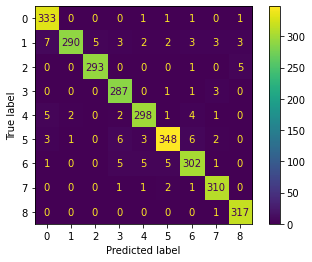

In [40]:
nccm.plot()

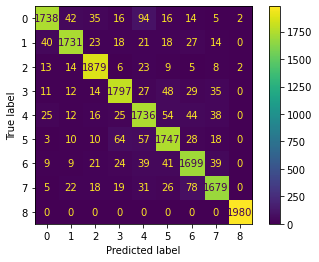

In [41]:
pccm.plot()